<h2> Load Data

In [ ]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import datetime
import pickle

In [ ]:
# load google drive to see the files in google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# directory where we save the logs
path = '/content/drive/MyDrive/Progetto-Vascon/DataLog'

In [ ]:
train_csv_path = '/content/drive/MyDrive/Progetto-Vascon/Dataset/cleaned_train.csv'
augmented_csv_path = '/content/drive/MyDrive/Progetto-Vascon/Dataset/cleaned_augmented.csv'
test_csv_path = '/content/drive/MyDrive/Progetto-Vascon/Dataset/cleaned_test.csv'

In [ ]:
train_df = pd.read_csv(train_csv_path)
augmented_df = pd.read_csv(augmented_csv_path)
test_df = pd.read_csv(test_csv_path)

In [ ]:
train_df.shape

(158115, 8)

In [ ]:
test_df.shape

(48733, 8)

<h2> Data preprocessing

In [ ]:
def plot_panoramic_words(df):
  df['text_len'] = [len(text.split()) for text in df['comment_text']]

  plt.figure(figsize=(30, 5))
  ax = sns.countplot(x='text_len', hue='text_len', data=df[df['text_len'] >= 150], palette='mako', legend=False)
  plt.title('Count of tweets with more than 150 words', fontsize=20)
  plt.yticks([])
  for p in ax.patches:
      ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
  plt.ylabel('Count')
  plt.xlabel('Tweet Length')
  plt.tight_layout()
  plt.show()

  print((df.sort_values(by=['text_len'], ascending=False))['comment_text'])

In [ ]:
def plot_labels_conut(df):
    df = df[['toxic',	'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate']]

    # Calculate the count of 1's in each column
    counts = df.sum()

    # Get colors from mako palette
    colors = sns.color_palette("mako", len(counts))

    # Plotting
    plt.figure(figsize=(5, 4))
    bars = plt.bar(counts.index, counts.values, color=colors)
    plt.title('Count of 1s in each column')
    plt.xlabel('Columns')
    plt.ylabel('Count of 1s')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adding color legend
    for bar, color in zip(bars, colors):
        bar.set_color(color)

    plt.tight_layout()
    plt.show()

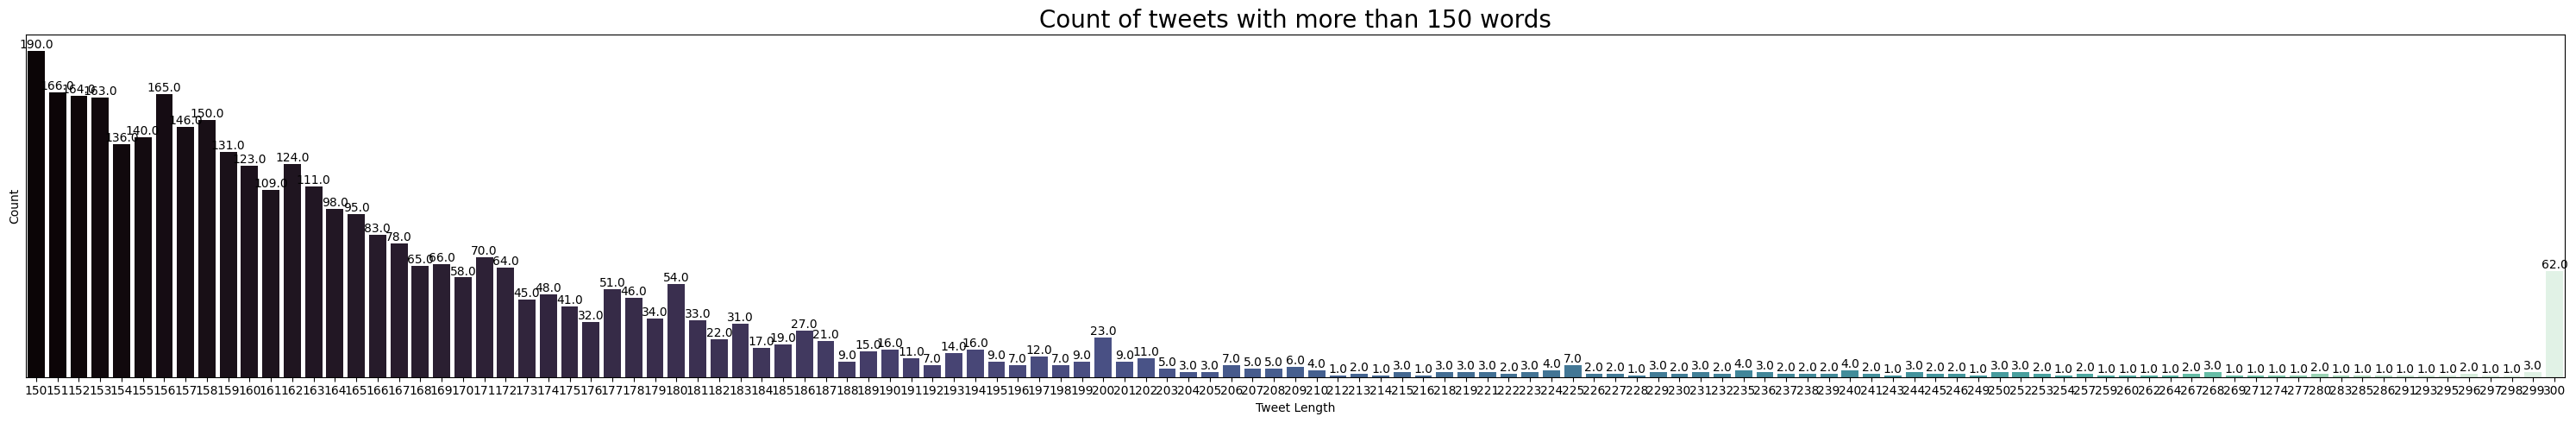

32018     pig pig pig pig pig pig pig pig pig pig pig pi...
127524    teabag teabag teabag teabag teabag teabag teab...
35173     marxismlong live anonym philippineslong live a...
93312     wiki noob wiki noob wiki noob wiki noob wiki n...
13030     fuck u bitchesfuck u bitchesfuck u bitchesfuck...
                                ...                        
88759                                           usersitush1
133763                                            interwiki
145608                                                 link
62385                                                  name
61676                                                 turtl
Name: comment_text, Length: 158115, dtype: object


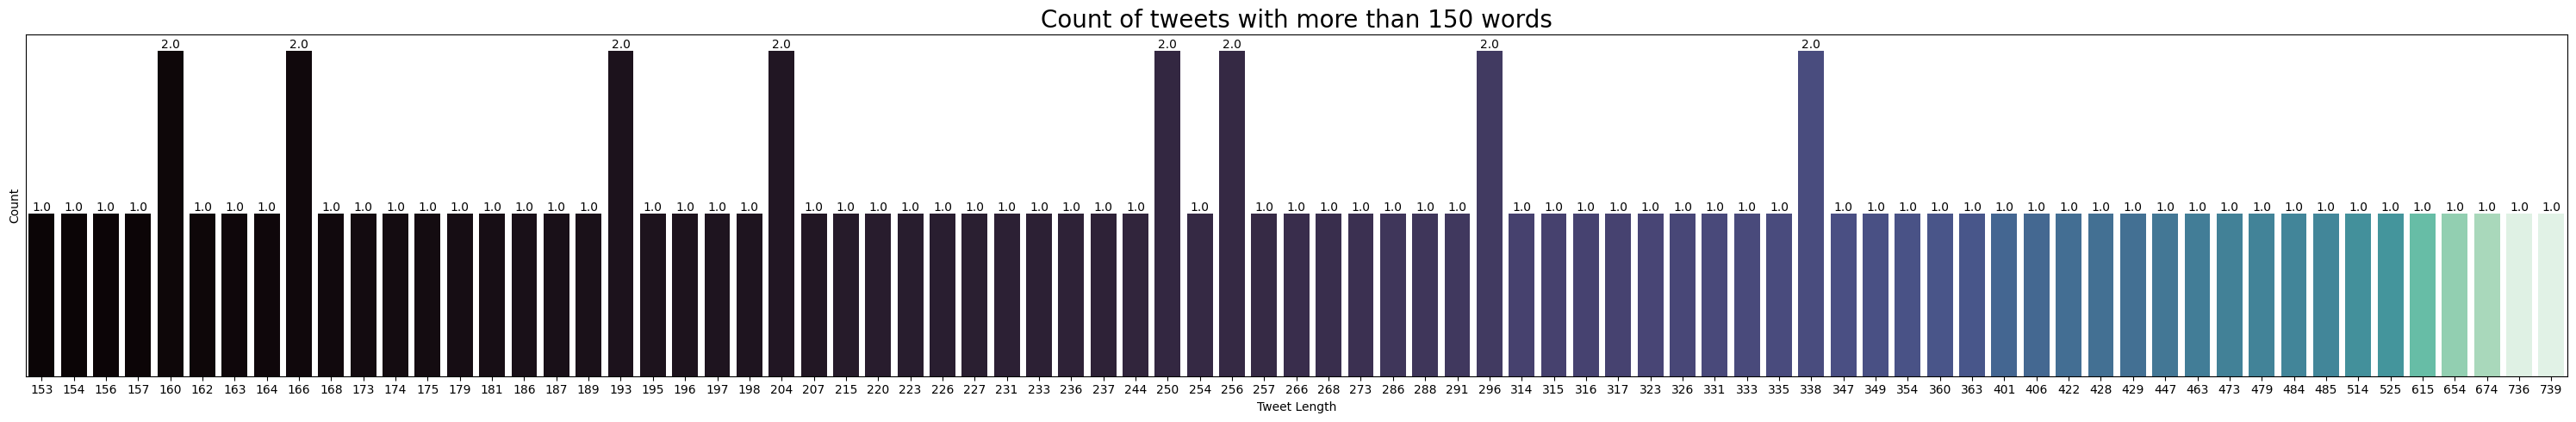

16892    cerdo cerdo de cerdo cerdo cerdo cerdo cerdo c...
16422    robert ullmann chupa dick robert ullmann chupa...
17800    sida sida sida aid aid aid aidsaid aid aid aid...
16990    eat shit die dog as nigga eat shit die dog as ...
16316    damn twat soldier posit artist band group song...
                               ...                        
12694                                                genit
594                                                   kiss
18875                                                 hate
5378                                                sexual
458                                                 vandal
Name: comment_text, Length: 20444, dtype: object


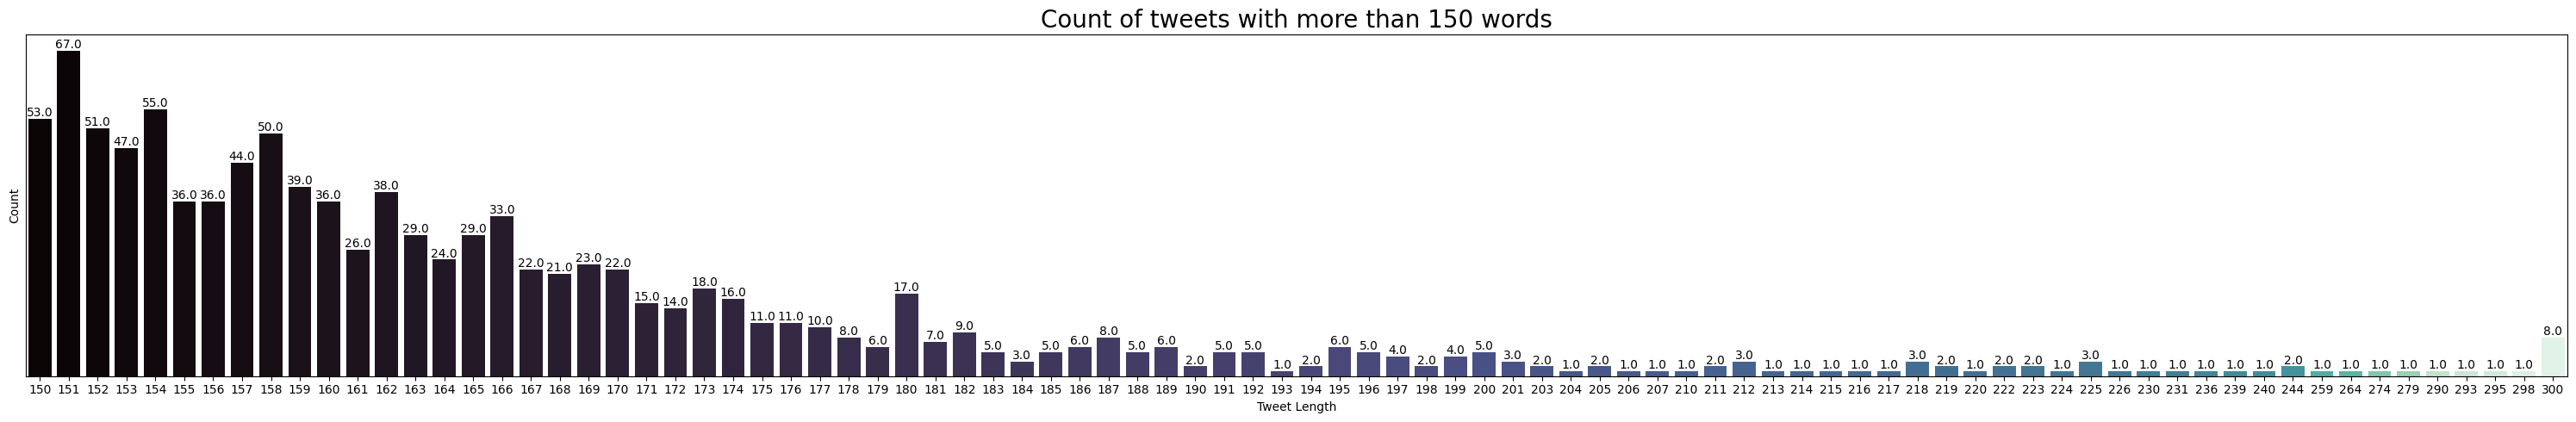

7407     anim rule comedi suck anim rule comedi suck an...
14331    butthol butthol butthol butthol butthol buttho...
2334     cunt cunt cunt cunt cunt cunt cunt cunt cunt c...
26182    faggot faggot faggot faggot faggot faggot fagg...
45176    fuck nigger cunt bitch whore nigger slut cunt ...
                               ...                        
11141                                               bclass
30265                                                  pyy
16038                                                 look
30228                                                 sort
47517                                               inspir
Name: comment_text, Length: 48733, dtype: object


In [ ]:
plot_panoramic_words(train_df)
plot_panoramic_words(augmented_df)
plot_panoramic_words(test_df)

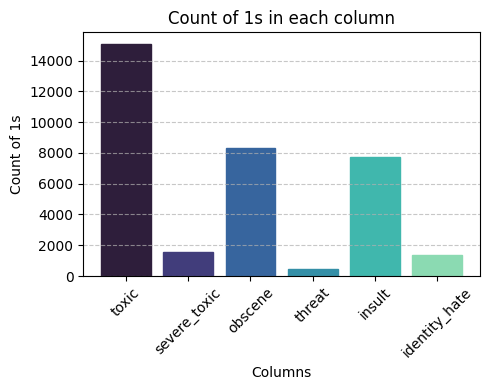

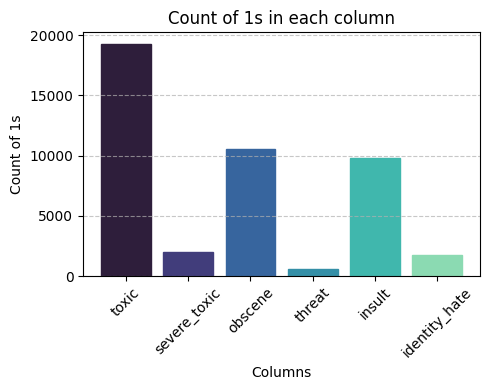

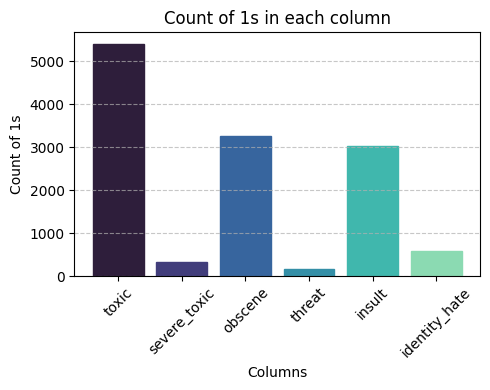

In [ ]:
plot_labels_conut(train_df)
plot_labels_conut(augmented_df)
plot_labels_conut(test_df)

<h2> BERT model

In [ ]:
import torch
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertModel
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from torch.utils.data import Dataset

In [ ]:
X_train = train_df['comment_text'].values
y_train = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

X_augmented = augmented_df['comment_text'].values
y_augmented = augmented_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values


In [ ]:
# add to train set the augmentation set, it will be used for bert
train_texts = np.concatenate((X_train, X_augmented), axis=0)
train_labels = np.concatenate((y_train, y_augmented), axis=0)

<h2> TRAIN BERT MODEL

# NO! DON'T RUN! or you will delete the model already trained

In [ ]:
# Load the tokenizer and BERT's pre-trained model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

# Tokenise texts and convert to tensors
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')

# Creating tensors for labels
train_labels = torch.tensor(train_labels, dtype=torch.float32)

# Creation of DataLoader to manage data during training and validation
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)

# Creation of DataLoader to manage data during training and validation
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


# parameters
optimizer = AdamW(model_bert.parameters(), lr=2e-5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bert.to(device)

# training model
num_epochs = 3
for epoch in range(num_epochs):

    # Training phase
    model_bert.train()
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training'):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model_bert(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()

# save the model
save_dir_bert = os.path.join(path, "bert_sequence_classification_trained")
model_bert.save_pretrained(save_dir_bert)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 3/3 - Training: 100%|██████████| 11160/11160 [20:26<00:00,  9.10it/s]


# yes, run it

In [ ]:
# Tokenizzazione del testo
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Caricare il modello addestrato
save_dir_bert = os.path.join(path, "bert_sequence_classification_trained")
model_bert = BertForSequenceClassification.from_pretrained(save_dir_bert)


def get_emb_cls_function_trained(df, column_name, model):

    sentences = df[column_name].tolist()

    inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True,  max_length=256)

    with torch.no_grad():
        # Ottenere l'output del modello
        outputs = model.bert(**inputs)

    last_hidden_state = outputs.last_hidden_state

    embeddings_words = last_hidden_state[:, 1:-1, :]   #(ignora [CLS] e [SEP])
    embedding_cls = last_hidden_state[:, 0, :]

    return embeddings_words, embedding_cls

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

<h2> CALCULATE BERT EMBEDDINGS

alleniamo su un dataset diverso per motivo che abbiamo risorse limitate

In [ ]:
train_csv_reduced_path = '/content/drive/MyDrive/Progetto-Vascon/Dataset/cleaned_train_reduced.csv'
test_csv_reduced_path = '/content/drive/MyDrive/Progetto-Vascon/Dataset/cleaned_test_reduced.csv'

In [ ]:
train_df = pd.read_csv(train_csv_reduced_path)
test_df = pd.read_csv(test_csv_reduced_path)

In [ ]:
train_df.shape

(72688, 8)

In [ ]:
test_df.shape

(62682, 8)

<h3> MODIFICARE!!!

In [ ]:
# RIDUCIAMO IL TRAIN E TEST

i = 2
train_df =  train_df.iloc[i*25000:(i+1)*25000]
test_df = test_df

[i*25000, (i+1)*25000]

[50000, 75000]

In [ ]:
X_test = test_df['comment_text'].values
y_test = test_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [ ]:
train_df , val_df = train_test_split(train_df, test_size=0.3, random_state=42)

X_val = val_df['comment_text'].values
y_val = val_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

val_df.shape

(6807, 8)

In [ ]:
X_train = train_df['comment_text'].values
y_train = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [ ]:
train_df.shape

(15881, 8)

In [ ]:
# Define the path where the embeddings will be saved
path = '/content/drive/MyDrive/Progetto-Vascon/DataLog'

In [ ]:
embeddings_words_train, embedding_cls_train = get_emb_cls_function_trained(train_df, "comment_text", model_bert)

print("Shape of BERT embeddings - train:", embeddings_words_train.shape)
print("Shape of CLS embeddings - train:", embedding_cls_train.shape)

Shape of BERT embeddings - train: torch.Size([15881, 254, 768])
Shape of CLS embeddings - train: torch.Size([15881, 768])


In [ ]:
file_words_train = f"embeddings_words_train__{i}.pkl"
file_cls_train = f"embedding_cls_train__{i}.pkl"

with open(os.path.join(path, 'embeddings', file_words_train), "wb") as f:
    pickle.dump(embeddings_words_train, f)

with open(os.path.join(path, 'embeddings', file_cls_train), "wb") as f:
    pickle.dump(embedding_cls_train, f)

np.save(os.path.join(path,'embeddings' ,f"y_train_{i}.npy"), y_train)
print("Embeddings saved successfully.")

Embeddings saved successfully.


In [ ]:
embeddings_words_val, embedding_cls_val = get_emb_cls_function_trained(val_df, "comment_text", model_bert)

print("Shape of BERT embeddings - validation:", embeddings_words_val.shape)
print("Shape of CLS embeddings - validation:", embedding_cls_val.shape)

Shape of BERT embeddings - validation: torch.Size([6807, 254, 768])
Shape of CLS embeddings - validation: torch.Size([6807, 768])


In [ ]:
file_words_val = f"embeddings_words_val__{i}.pkl"
file_cls_val = f"embedding_cls_val__{i}.pkl"

with open(os.path.join(path, 'embeddings', file_words_val), "wb") as f:
    pickle.dump(embeddings_words_val, f)

with open(os.path.join(path, 'embeddings',  file_cls_val), "wb") as f:
    pickle.dump(embedding_cls_val, f)

np.save(os.path.join(path,'embeddings' ,f"y_val_{i}.npy"), y_val)
print("Embeddings saved successfully.")

In [ ]:
test_df_1 = test_df.loc[(test_df == 1).any(axis=1)]
test_df_1

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
8,00091c35fa9d0465,arab commit genocid iraq protest europ may eur...,1,0,0,0,0,0
23,0013fed3aeae76b7,dj robinson gay hell suck dick much,1,0,1,0,1,1
28,0017d4d47894af05,fuck antisemit cunt,1,0,1,0,1,0
37,001d739c97bc2ae4,dare vandal page hm beagl dont vandal demon,1,0,0,0,0,0
39,001eff4007dbb65b,arrog self serv immatur idiot get right,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...
62582,ff91c3d8a3e34398,nigel crazi idiot,1,0,0,0,1,0
62639,ffd49b8defd069d0,well dont feel stupid,0,0,0,0,1,0
62649,ffdf6854b41d9102,fourth baldrick possibl clever made anyon el s...,1,0,0,0,0,0
62666,ffebe90c8d5acaba,iran right iran drone spread homosexu western ...,1,0,1,0,0,0


In [ ]:
labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
test_df_filtered = np.where(np.all(test_df[labels] == [0,0,0,0,0,0], axis=1))[0]
test_df_0 = test_df.loc[test_df.index.isin(test_df_filtered[:18848])]
test_df_0

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,thank understand think highli would revert wit...,0,0,0,0,0,0
1,000247e83dcc1211,dear god site horribl,0,0,0,0,0,0
2,0002f87b16116a7f,somebodi invari tri add religion realli mean w...,0,0,0,0,0,0
3,0003e1cccfd5a40a,say right type type institut need case three l...,0,0,0,0,0,0
4,00059ace3e3e9a53,ad new product list make sure relev ad new pro...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
20869,541619db5a11702c,screw obamabold text,0,0,0,0,0,0
20870,54164b24b4d941e5,feel enough inform birth date death date vice ...,0,0,0,0,0,0
20871,5416f7990e909db0,welcom hello chanman welcom wikipedia thank co...,0,0,0,0,0,0
20872,5417ef2f1f68cf54,ad licen section bot tag page see diff templat...,0,0,0,0,0,0


In [ ]:
test_df = pd.concat([test_df_0, test_df_1], ignore_index=True)
test_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,thank understand think highli would revert wit...,0,0,0,0,0,0
1,000247e83dcc1211,dear god site horribl,0,0,0,0,0,0
2,0002f87b16116a7f,somebodi invari tri add religion realli mean w...,0,0,0,0,0,0
3,0003e1cccfd5a40a,say right type type institut need case three l...,0,0,0,0,0,0
4,00059ace3e3e9a53,ad new product list make sure relev ad new pro...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
24995,ff91c3d8a3e34398,nigel crazi idiot,1,0,0,0,1,0
24996,ffd49b8defd069d0,well dont feel stupid,0,0,0,0,1,0
24997,ffdf6854b41d9102,fourth baldrick possibl clever made anyon el s...,1,0,0,0,0,0
24998,ffebe90c8d5acaba,iran right iran drone spread homosexu western ...,1,0,1,0,0,0


In [ ]:
embeddings_words_test, embedding_cls_test = get_emb_cls_function_trained(test_df, "comment_text", model_bert)


print("Shape of BERT embeddings - test:", embeddings_words_test.shape)
print("Shape of CLS embeddings - test:", embedding_cls_test.shape)

Shape of BERT embeddings - test: torch.Size([25000, 254, 768])
Shape of CLS embeddings - test: torch.Size([25000, 768])


In [ ]:

file_words_test = "embeddings_words_test_large.pkl"
file_cls_test = "embedding_cls_test_large.pkl"

with open(os.path.join(path, 'embeddings', file_words_test), "wb") as f:
    pickle.dump(embeddings_words_test, f)

with open(os.path.join(path, 'embeddings', file_cls_test), "wb") as f:
    pickle.dump(embedding_cls_test, f)


In [ ]:
y_test = test_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
np.save(os.path.join(path,'embeddings' ,"y_test_large.npy"), y_test)
print("Embeddings saved successfully.")